## The goals for this Advanced Lane Finding Project project are:

### -- Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
### -- Apply a distortion correction to raw images.
### -- Use color transforms, gradients, etc., to create a thresholded binary image.
### -- Apply a perspective transform to rectify binary image ("birds-eye view").
### -- Detect lane pixels and fit to find the lane boundary.
### -- Determine the curvature of the lane and vehicle position with respect to center.
### -- Warp the detected lane boundaries back onto the original image.
### -- Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

### Python Code for the Advanced Lane Finding project:

### Import the necessary packages

In [31]:
#from moviepy.editor import VideoFileClip
from IPython.display import HTML
import numpy as np
import cv2
import pickle
import glob
from tracker import tracker
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.gridspec as gridspec
import h5py
import os



### I prepared the "object points", which are the three dimensions of the chessboard corners in the real world. The object points are reshaped to create "image points" which are two dimensional coordinates in the image plane. OpenCV functions findChessboardCorners() and drawChessboardCorners() were used to automatically find and draw corners in an image of a chessboard pattern.

### I then used the output objpoints and imgpoints to compute the camera calibration and distortion coefficients using the cv2.calibrateCamera() function. I applied this distortion correction to the test image using the cv2.undistort() function and obtained this result:

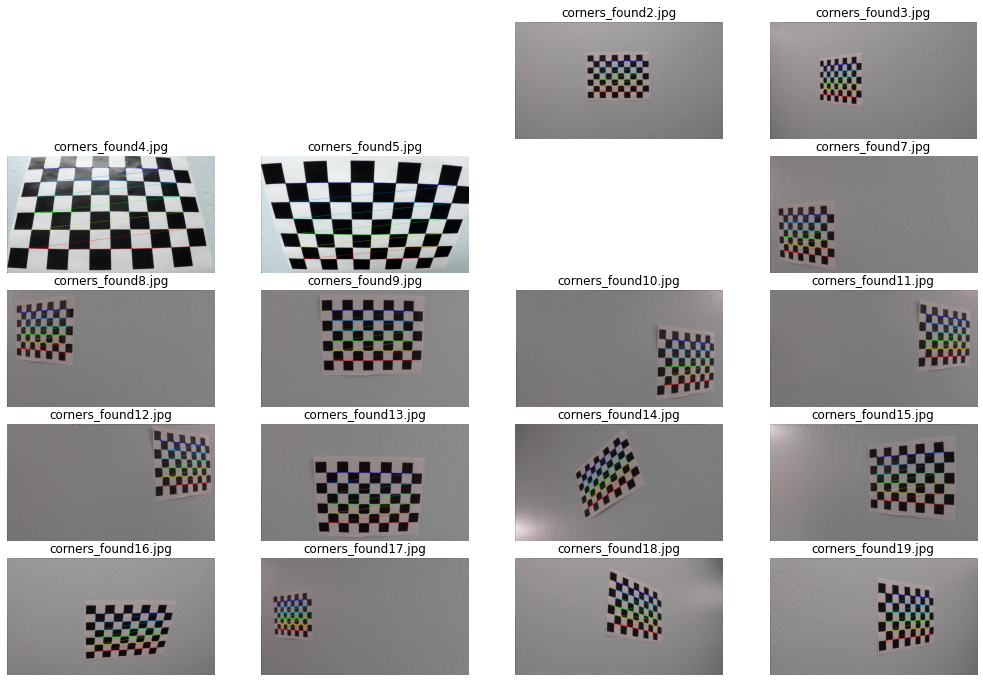

In [32]:
# Calibrate the Camera
# number of inside corners in x & y directions
nx = 9 
ny = 6
# prepare object points
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane

# Make a list of calibration images
images = glob.glob('./camera_cal/calibration*.jpg')

plt.figure(figsize = (18,12))
grid = gridspec.GridSpec(5,4)
# set the spacing between axes.
grid.update(wspace=0.05, hspace=0.15)  

for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

    # If found, add to object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
        write_name = 'corners_found'+str(idx)+'.jpg'
        #cv2.imwrite(write_name,img)
        img_plt = plt.subplot(grid[idx])
        plt.axis('on')
        img_plt.set_xticklabels([])
        img_plt.set_yticklabels([])
        #img_plt.set_aspect('equal')
        plt.imshow(img)
        plt.title(write_name)
        plt.axis('off')
plt.show()
    #plt.axis('off')

### It should be noted that some of the images are not plotted above because the "findChessboardCorners()" function could not find 9 x 6 inside corners inside these input images

### Use the objpoints and imgpoints to compute the camera calibration and distortion coefficients using the cv2.calibrateCamera() function. This distortion correction was applied to the test image using the cv2.undistort() function. The results are shown below

In [33]:
# Take an image, object points, image points, and perform the camera calibration. Undistort the image after camera calibration
        
#load image for reference
#image = cv2.imread('./camera_cal/calibration1.jpg')
#img_size = (image.shape[1],image.shape[0])

# Perform camera calibration with the given object and image points
#ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)

# Save the camera calibration results for later use
filename = "camera_intrinsics.h5"
main_K, main_distortion = None, None

#Extracts the intrinsic K matrix and distortion vector from the h5 file
with h5py.File(filename, "r") as data:

    main_K = np.array(data["main"]["K"])
    main_distortion = np.array(data["main"]["distortion"])
dist_pickle = {}
k = main_K
dst = main_distortion
pickle.dump(dist_pickle, open("./camera_cal/calibration_pickle.p", "wb"))

#Visualize the before/after distortion on chessboard images
undist = cv2.undistort(image, k, dst, None, k)
plt.figure(figsize = (18,12))
grid = gridspec.GridSpec(1,2)
# set the spacing between axes.
grid.update(wspace=0.1, hspace=0.1)  

img_plt = plt.subplot(grid[0])
plt.imshow(image)
plt.title('Original Image')

img_plt = plt.subplot(grid[1])
plt.imshow(undist)
plt.title('Undistorted Image')

plt.show()


NameError: name 'image' is not defined

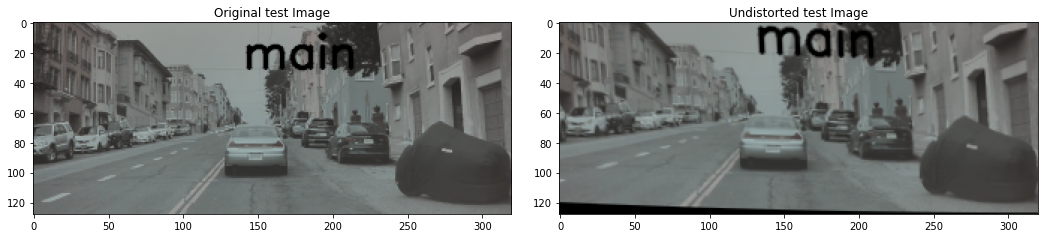

In [34]:
# Choose from the test images to demonstrate the before/after applying undistortion 
testImg = cv2.imread('./test_images/0141.png')
testImg = cv2.cvtColor(testImg, cv2.COLOR_BGR2RGB)


undistTest = cv2.undistort(testImg, k, dst, None, k)

#Visualize the before/after distortion on test images
plt.figure(figsize = (18,12))
grid = gridspec.GridSpec(1,2)
# set the spacing between axes.
grid.update(wspace=0.1, hspace=0.1)  

img_plt = plt.subplot(grid[0])
plt.imshow(testImg)
plt.title('Original test Image')

img_plt = plt.subplot(grid[1])
plt.imshow(undistTest)
plt.title('Undistorted test Image')


plt.show()

### Although it may not be visible at a first glance, a closer look at the sides of the undistorted image above shows that the radial distortion has been removed. An example where this is obvious: the white car on the right is slightly cropped along with the trees

### Some useful functions are defined for experimenting with different color thresholds and gradients

In [35]:
# Define a function that takes an image, gradient orientation,
# and threshold min / max values.

def abs_sobel_thresh(img, orient='x', thresh_min=25, thresh_max=255):
    # Convert to grayscale
    # gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(l_channel, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(l_channel, cv2.CV_64F, 0, 1))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

    # Return the result
    return binary_output

# Define a function to return the magnitude of the gradient for a given sobel kernel size and threshold values
def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    # Return the binary image
    return binary_output

# Define a function to threshold an image for a given range and Sobel kernel
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return binary_output

def color_threshold(image, sthresh=(0,255), vthresh=(0,255), hthresh=(0, 255)):
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel > sthresh[0]) & (s_channel <= sthresh[1])] = 1

    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    v_channel = hsv[:,:,2]
    v_binary = np.zeros_like(v_channel)
    v_binary[(v_channel > vthresh[0]) & (v_channel <= vthresh[1])] = 1
    
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    h_channel = hsv[:,:,0]
    h_binary = np.zeros_like(h_channel)
    h_binary[(h_channel > hthresh[0]) & (h_channel <= hthresh[1])] = 1

    output = np.zeros_like(s_channel)
    output[(s_binary == 1) & (v_binary == 1) & (h_binary == 1)] = 1

    # Return the combined s_channel & v_channel binary image
    return output

def s_channel_threshold(image, sthresh=(0,255)):
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    s_channel = hls[:, :, 2]  # use S channel

    # create a copy and apply the threshold
    binary_output = np.zeros_like(s_channel)
    binary_output[(s_channel >= sthresh[0]) & (s_channel <= sthresh[1])] = 1
    return binary_output

def window_mask(width, height, img_ref, center, level):
    output = np.zeros_like(img_ref)
    output[int(img_ref.shape[0]-(level+1)*height):int(img_ref.shape[0]-level*height), max(0,int(center-width)):min(int(center+width),img_ref.shape[1])] = 1
    return output

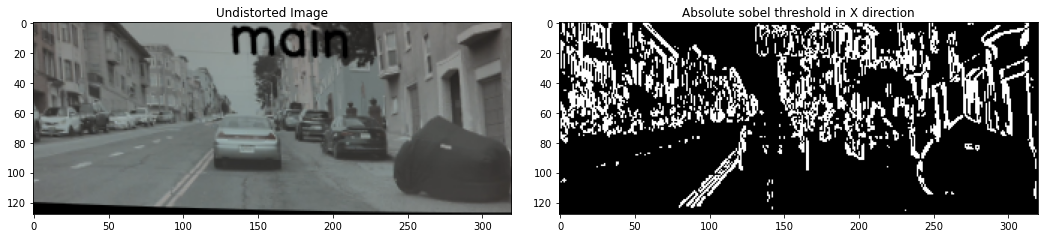

In [36]:
#Apply Sobel operator in X-direction to experiment with gradient thresholds
gradx = abs_sobel_thresh(undistTest, orient='x', thresh_min=20, thresh_max=100)

#Visualize the results before/after absolute sobel operator is applied on a test image in x direction to find the
#vertical lines, since the lane lines are close to being vertical
plt.figure(figsize = (18,12))
grid = gridspec.GridSpec(1,2)

# set the spacing between axes.
grid.update(wspace=0.1, hspace=0.1)  

plt.subplot(grid[0])
plt.imshow(undistTest, cmap="gray")
plt.title('Undistorted Image')

plt.subplot(grid[1])
plt.imshow(gradx, cmap="gray")
plt.title('Absolute sobel threshold in X direction')

plt.show()

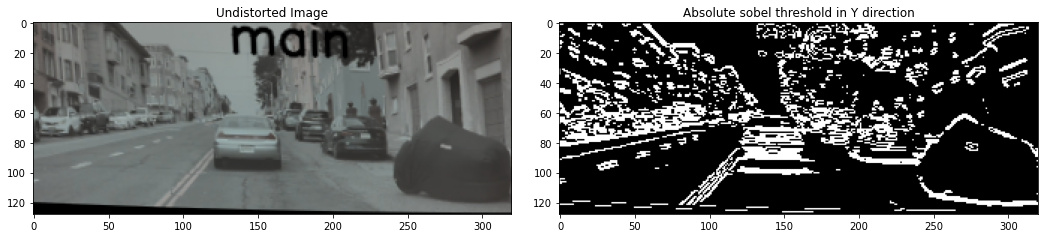

In [37]:
#Apply Sobel operator in Y-direction to experiment with gradient thresholds
grady = abs_sobel_thresh(undistTest, orient='y', thresh_min=20, thresh_max=100)

#Visualize the results before/after sobel operator is applied on a test image in y direction 
plt.figure(figsize = (18,12))
grid = gridspec.GridSpec(1,2)

# set the spacing between axes.
grid.update(wspace=0.1, hspace=0.1)  

plt.subplot(grid[0])
plt.imshow(undistTest, cmap="gray")
plt.title('Undistorted Image')

plt.subplot(grid[1])
plt.imshow(grady, cmap="gray")
plt.title('Absolute sobel threshold in Y direction')

plt.show()

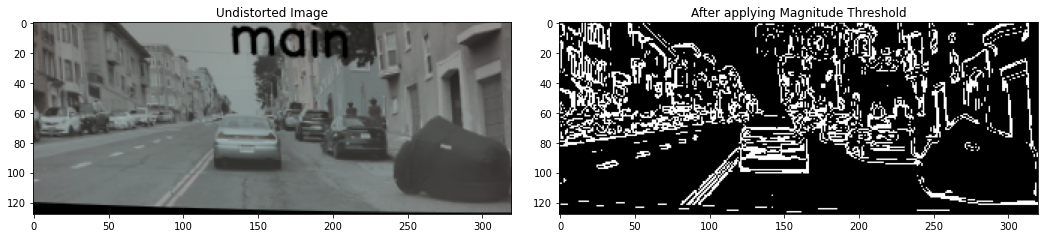

In [38]:
#Apply magnitude threshold
magThr = mag_thresh(undistTest, sobel_kernel=3, mag_thresh=(30, 70))

#Visualize the results before/after applying magnitude thresholds
plt.figure(figsize = (18,12))
grid = gridspec.GridSpec(1,2)

# set the spacing between axes.
grid.update(wspace=0.1, hspace=0.1)  

plt.subplot(grid[0])
plt.imshow(undistTest, cmap="gray")
plt.title('Undistorted Image')

plt.subplot(grid[1])
plt.imshow(magThr, cmap="gray")
plt.title('After applying Magnitude Threshold')

plt.show()

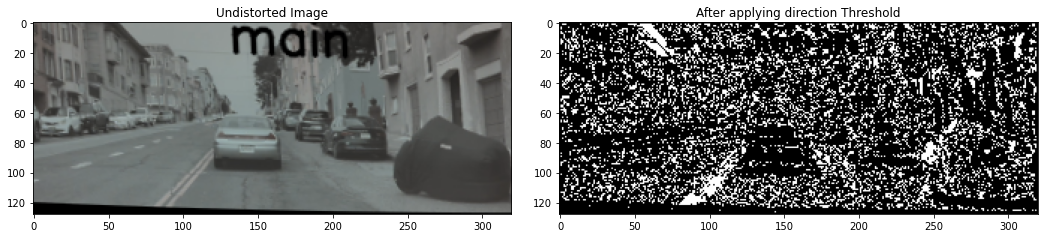

In [39]:
dirThr = dir_threshold(undistTest, sobel_kernel=3, thresh=(0.5, 1))

#Visualize the results before/after direction threshold is applied
plt.figure(figsize = (18,12))
grid = gridspec.GridSpec(1,2)

# set the spacing between axes.
grid.update(wspace=0.1, hspace=0.1)  

plt.subplot(grid[0])
plt.imshow(undistTest, cmap="gray")
plt.title('Undistorted Image')

plt.subplot(grid[1])
plt.imshow(dirThr, cmap="gray")
plt.title('After applying direction Threshold')

plt.show()

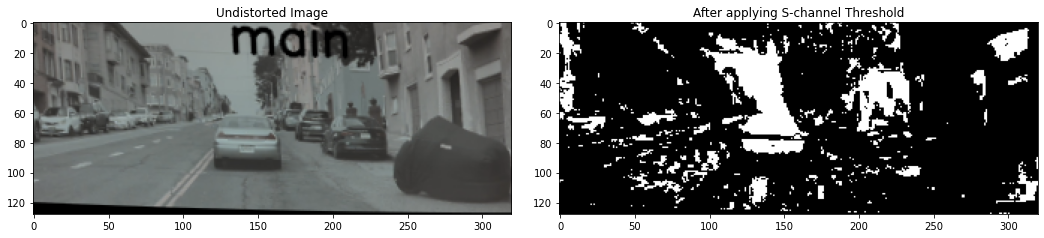

In [40]:
#use s channel alone in HLS colorspace and experiment with thresholds
s_binary = s_channel_threshold(undistTest, sthresh=(10,255))

#Visualize the results before/after s channel threshold is applied
plt.figure(figsize = (18,12))
grid = gridspec.GridSpec(1,2)
# set the spacing between axes.
grid.update(wspace=0.1, hspace=0.1)  

plt.subplot(grid[0])
plt.imshow(undistTest, cmap="gray")
plt.title('Undistorted Image')

plt.subplot(grid[1])
plt.imshow(s_binary, cmap="gray")
plt.title('After applying S-channel Threshold')

plt.show()

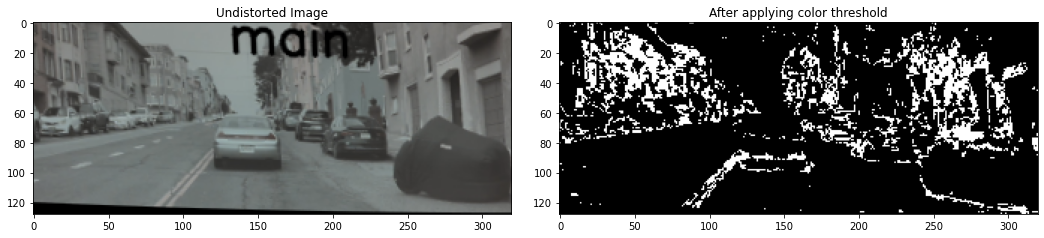

In [70]:
#Experiment with HLS & HSV color spaces along with thresholds
c_binary = color_threshold(undistTest, sthresh=(0,100), vthresh=(0,255), hthresh=(30,70))

#Visualize the results before/after HLS/HSV  threshold is applied
plt.figure(figsize = (18,12))
grid = gridspec.GridSpec(1,2)

# set the spacing between axes.
grid.update(wspace=0.1, hspace=0.1)  

plt.subplot(grid[0])
plt.imshow(undistTest, cmap="gray")
plt.title('Undistorted Image')

plt.subplot(grid[1])
plt.imshow(c_binary, cmap="gray")
plt.title('After applying color threshold')

plt.show()

### After experimenting with several thresholds and color spaces, I chose to use the combined binary thresholded image from the Sobel threshold in the x & y directions along with the color thresholds in the H & V channels, to get clear lane lines in all the test images. This forms the image processing pipeline for generating a thresholded binary image

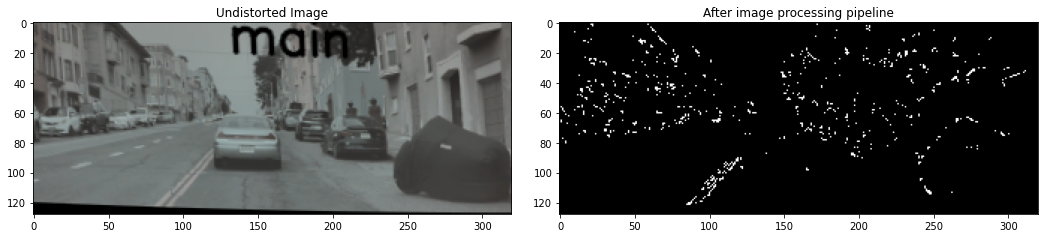

In [73]:
#Combine the binary images using the Sobel thresholds in X/Y directions along with the color threshold to form the final image pipeline
preprocessImage = np.zeros_like(undistTest[:,:,0])
preprocessImage[((gradx == 1) & (grady ==1) & (c_binary == 1))] = 255

#Visualize the results before/after combining the images from the pipeline
plt.figure(figsize = (18,12))
grid = gridspec.GridSpec(1,2)

# set the spacing between axes.
grid.update(wspace=0.1, hspace=0.1)  

plt.subplot(grid[0])
plt.imshow(undistTest, cmap="gray")
plt.title('Undistorted Image')

plt.subplot(grid[1])
plt.imshow(preprocessImage, cmap="gray")
plt.title('After image processing pipeline')

plt.show()



### Read the test images, pass them through the pipeline, warp the perspective by selecting a region of interest within the image, and create a bird's eye view. Visualize the results and ensure that the selected region of interest is appropriate by confirming that the lane lanes are indeed parallel to each other after warping the image

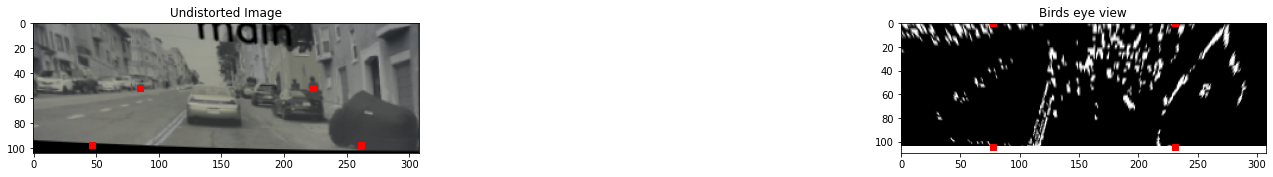

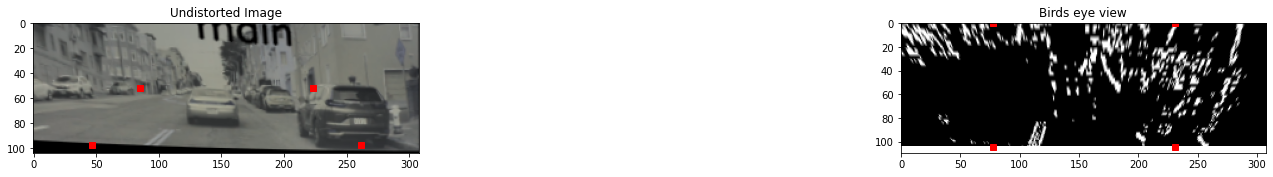

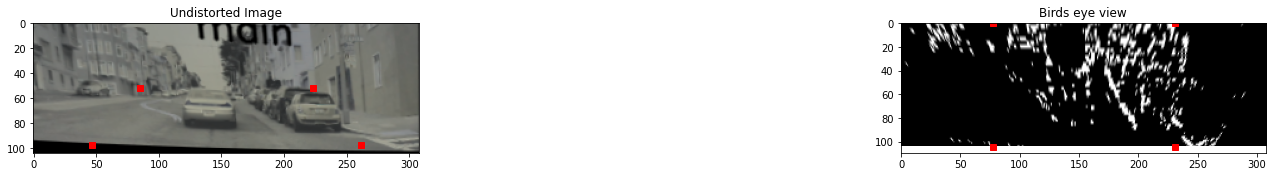

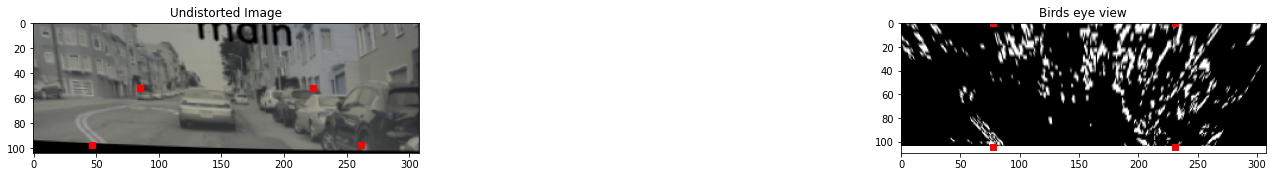

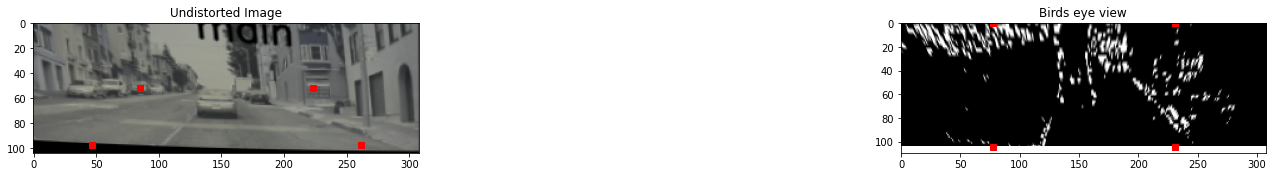

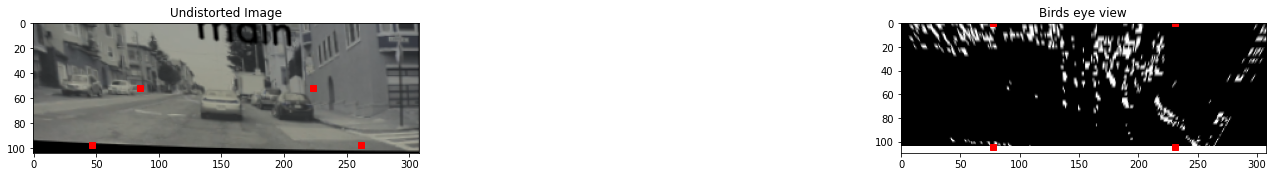

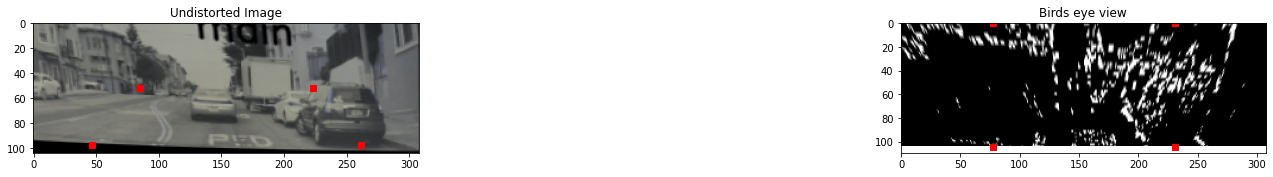

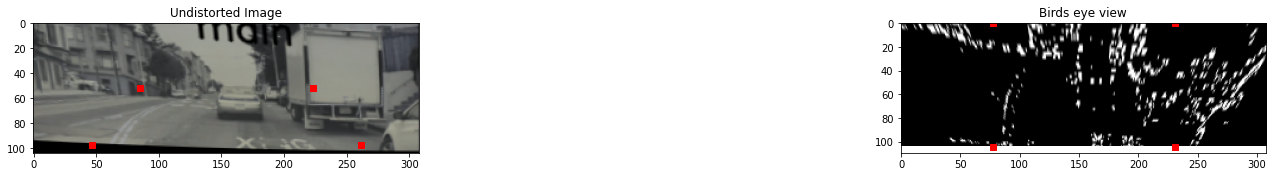

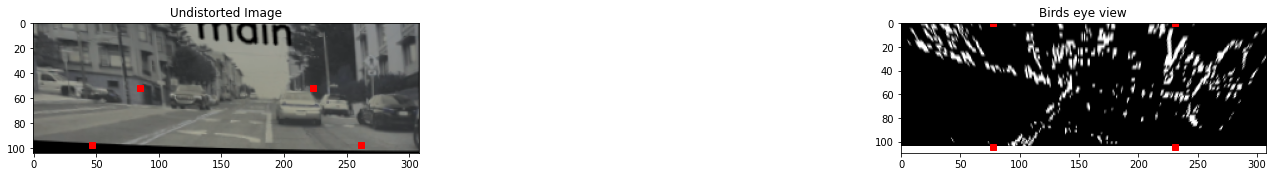

In [82]:
# Read and make a list of test images
images = glob.glob('./less_test_images/*.png')
images.sort()
gidx = 0

for idx,fname in enumerate(images):
    #read in image
    img = cv2.imread(fname)
    #undistort the image
    img = cv2.undistort(img,main_K,main_distortion,None,main_K)
    
    #pass image thru the pipeline
    preprocessImage = np.zeros_like(img[:,:,0])
    gradx = abs_sobel_thresh(img, orient='x', thresh_min=12, thresh_max=255)
    grady = abs_sobel_thresh(img, orient='y', thresh_min=25, thresh_max=255)
    c_binary = color_threshold(img, sthresh=(100,255), vthresh=(50,255))
    preprocessImage[((gradx == 1) & (grady ==1) | (c_binary == 1))] = 255
    
    img_size = (img.shape[1],img.shape[0])

    bot_width = .7 # percentage of bottom trapezoidal height
    mid_width = .45 # percentage of mid trapezoidal height
    height_pct = .5 # percentage of trapezoidal height
    bottom_trim= .935 # percentage from top to bottom avoiding the hood of the car

    src = np.float32([[img.shape[1]*(0.5-mid_width/2), img.shape[0]*height_pct],[img.shape[1]*(0.5+mid_width/2),img.shape[0]*height_pct],[img.shape[1]*(0.5+bot_width/2), img.shape[0]*bottom_trim],[img.shape[1]*(0.5-bot_width/2), img.shape[0]*bottom_trim]])
    offset = img_size[0]*0.25
    dst = np.float32([[offset,0],[img_size[0]-offset,0],[img_size[0]-offset,img_size[1]],[offset,img_size[1]]])
    
    #perform the warp perspective transform
    M = cv2.getPerspectiveTransform(src,dst)
    Minv = cv2.getPerspectiveTransform(dst,src)
    warped = cv2.warpPerspective(preprocessImage,M,img_size,flags=cv2.INTER_LINEAR)

    #Visualize the results before/after warping for a birds-eye view along with the source & destination co-ordinate locations
    plt.figure(figsize = (30,20))
    grid = gridspec.GridSpec(8,2)
    # set the spacing between axes.
    grid.update(wspace=0.05, hspace=0.05)  

    plt.subplot(grid[gidx])
    plt.imshow(img, cmap="gray")
    for i in range(4):
        plt.plot(src[i][0],src[i][1],'rs')
    plt.title('Undistorted Image')

    plt.subplot(grid[gidx+1])
    plt.imshow(warped, cmap="gray")
    for i in range(4):
        plt.plot(dst[i][0],dst[i][1],'rs')
    plt.title('Birds eye view')

plt.show()


### Apply convolution which will maximize the number of "hot" pixels in each window. This convolution is the summation of the product of two separate signals: the window template and the vertical slice of the pixel image. The window template is slid across the image from left to right and any overlapping values are summed together, creating the convolved signal. The peak of the convolved signal is where the highest overlap of pixels occured and is the position for the lane marker.

/var/folders/jk/c2vv5jfn57342g7qq5mmcnwc0000gn/T/ipykernel_41124/1329090998.py:7: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)


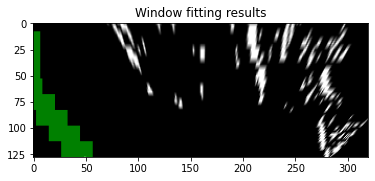

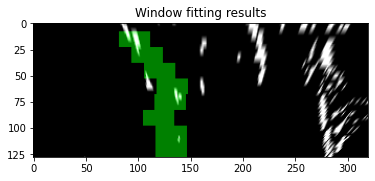

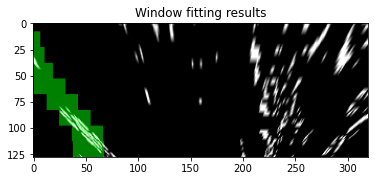

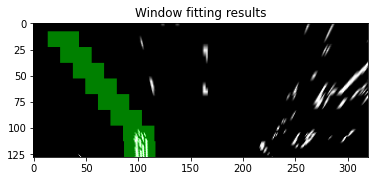

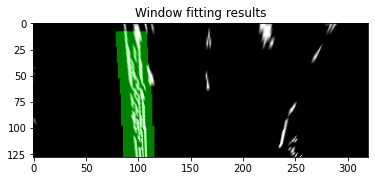

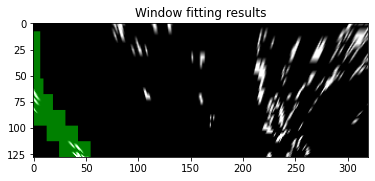

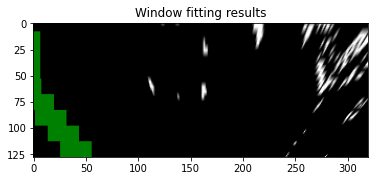

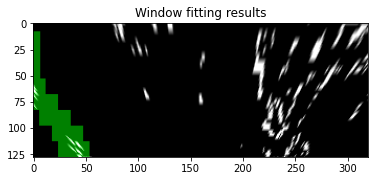

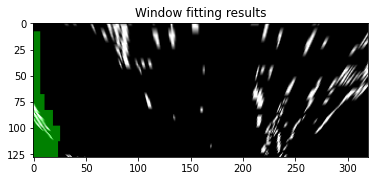

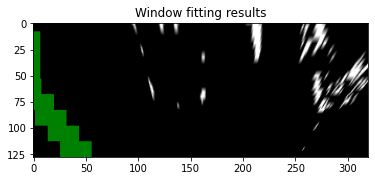

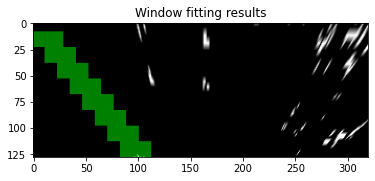

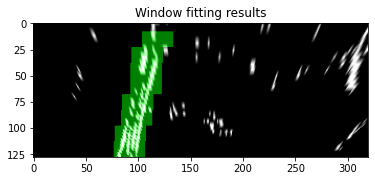

In [119]:
for idx,fname in enumerate(images):
    #read in image
    img = cv2.imread(fname)
    #undistort the image
    img = cv2.undistort(img,main_K,main_distortion,None,main_K)
    
    #pass image thru the pipeline
    preprocessImage = np.zeros_like(img[:,:,0])
    gradx = abs_sobel_thresh(img, orient='x', thresh_min=12, thresh_max=255)
    grady = abs_sobel_thresh(img, orient='y', thresh_min=25, thresh_max=255)
    c_binary = color_threshold(img, sthresh=(100,255), vthresh=(50,255))
    preprocessImage[((gradx == 1) & (grady ==1) | (c_binary == 1))] = 255
    
    img_size = (img.shape[1],img.shape[0])


    
    bot_width = .63 # percentage of bottom trapezoidal height
    mid_width = .32 # percentage of mid trapezoidal height
    height_pct = .7 # percentage of trapezoidal height
    bottom_trim= .935 # percentage from top to bottom avoiding the hood of the car


    
    src = np.float32([[img.shape[1]*(0.5-mid_width/2), img.shape[0]*height_pct],[img.shape[1]*(0.5+mid_width/2),img.shape[0]*height_pct],[img.shape[1]*(0.5+bot_width/2), img.shape[0]*bottom_trim],[img.shape[1]*(0.5-bot_width/2), img.shape[0]*bottom_trim]])
    offset = img_size[0]*0.25
    dst = np.float32([[offset,0],[img_size[0]-offset,0],[img_size[0]-offset,img_size[1]],[offset,img_size[1]]])
   
    #perform the warp perspective transform
    M = cv2.getPerspectiveTransform(src,dst)
    Minv = cv2.getPerspectiveTransform(dst,src)
    warped = cv2.warpPerspective(preprocessImage, M, img_size, flags=cv2.INTER_LINEAR)
    
    window_width = 15
    window_height = 15
    
    #set up the overall class to do the lane line tracking
    curve_centers = tracker(Mywindow_width=window_width, Mywindow_height=window_height, Mymargin = 12, My_ym = 10/720, My_xm = 4/384, Mysmooth_factor=15)
    
    window_centroids = curve_centers.find_window_centroids(warped)
    
    # Points used to draw all the left and right windows
    l_points = np.zeros_like(warped)
    r_points = np.zeros_like(warped)
        
    # points used to find the right & left lanes
    rightx = []
    leftx = []

    # Go through each level and draw the windows 
    for level in range(0,len(window_centroids)):
        # Window_mask is a function to draw window areas
        # Add center value found in frame to the list of lane points per left, right
        leftx.append(window_centroids[level][0])
        rightx.append(window_centroids[level][1])

        l_mask = window_mask(window_width,window_height,warped,window_centroids[level][0],level)
        r_mask = window_mask(window_width,window_height,warped,window_centroids[level][1],level)
        # Add graphic points from window mask here to total pixels found 
        l_points[(l_points == 255) | ((l_mask == 1) ) ] = 255
        r_points[(r_points == 255) | ((r_mask == 1) ) ] = 255

    # Draw the results
    template = np.array(l_points,np.uint8) #template = np.array(r_points+l_points,np.uint8) # add both left and right window pixels together
    zero_channel = np.zeros_like(template) # create a zero color channel
    template = np.array(cv2.merge((zero_channel,template,zero_channel)),np.uint8) # make window pixels green
    warpage = np.array(cv2.merge((warped,warped,warped)),np.uint8) # making the original road pixels 3 color channels
    result = cv2.addWeighted(warpage, 1, template, 0.5, 0.0) # overlay the original road image with window results

    #Visualize the results of the window fitting to lane lines
    plt.imshow(result, cmap='gray')
    plt.title('Window fitting results')
    plt.show()

### Fit a polynomial to the identified lane lines on the left and the right. Visualize the results by overlapping the lane lines on to the original undistorted image

/var/folders/jk/c2vv5jfn57342g7qq5mmcnwc0000gn/T/ipykernel_41124/1329090998.py:7: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)


len(res_rvals) [120.5 105.5  90.5  75.5  60.5  45.5  30.5  15.5] 
len leftx [42.5, 30.5, 18.5, 6.5, -5.5, -7.5, -7.5, -7.5]

 (128, 320)
len(res_rvals) [120.5 105.5  90.5  75.5  60.5  45.5  30.5  15.5] 
len leftx [132.5, 132.5, 120.5, 131.5, 133.5, 121.5, 109.5, 97.5]

 (128, 320)
len(res_rvals) [120.5 105.5  90.5  75.5  60.5  45.5  30.5  15.5] 
len leftx [53.5, 52.5, 40.5, 28.5, 16.5, 4.5, -3.5, -7.5]

 (128, 320)
len(res_rvals) [120.5 105.5  90.5  75.5  60.5  45.5  30.5  15.5] 
len leftx [102.5, 101.5, 89.5, 77.5, 65.5, 53.5, 41.5, 29.5]

 (128, 320)
len(res_rvals) [120.5 105.5  90.5  75.5  60.5  45.5  30.5  15.5] 
len leftx [101.5, 101.5, 99.5, 99.5, 98.5, 96.5, 95.5, 94.5]

 (128, 320)
len(res_rvals) [120.5 105.5  90.5  75.5  60.5  45.5  30.5  15.5] 
len leftx [40.5, 28.5, 16.5, 4.5, -4.5, -7.5, -7.5, -7.5]

 (128, 320)
len(res_rvals) [120.5 105.5  90.5  75.5  60.5  45.5  30.5  15.5] 
len leftx [41.5, 29.5, 17.5, 5.5, -6.5, -7.5, -7.5, -7.5]

 (128, 320)
len(res_rvals) [120.5 105.5

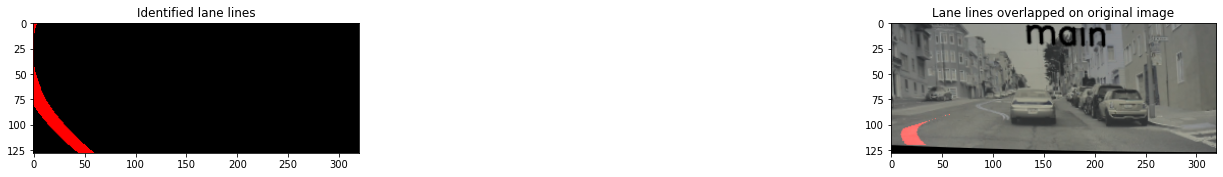

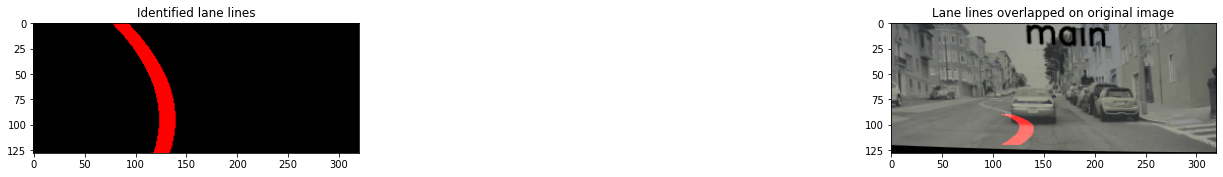

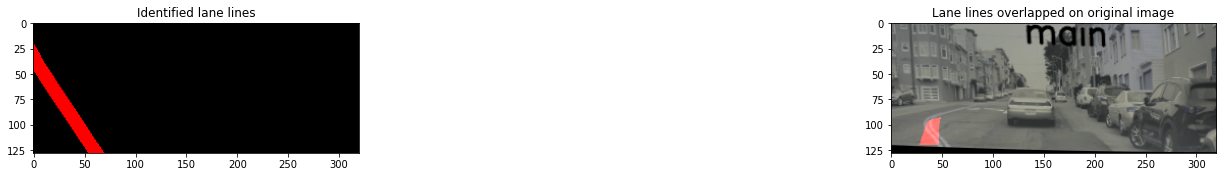

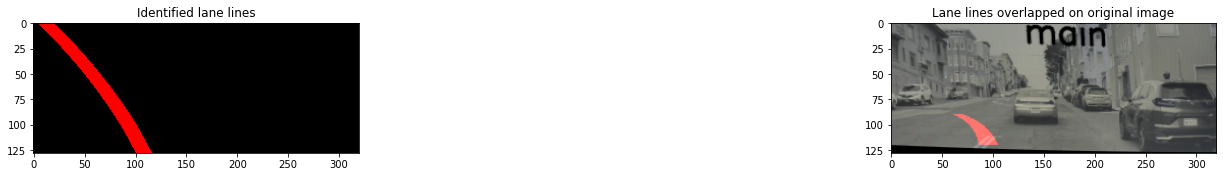

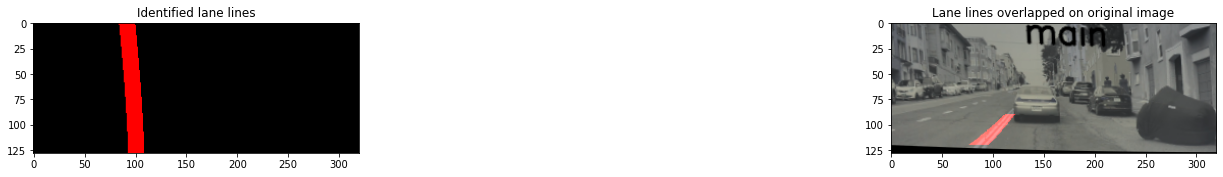

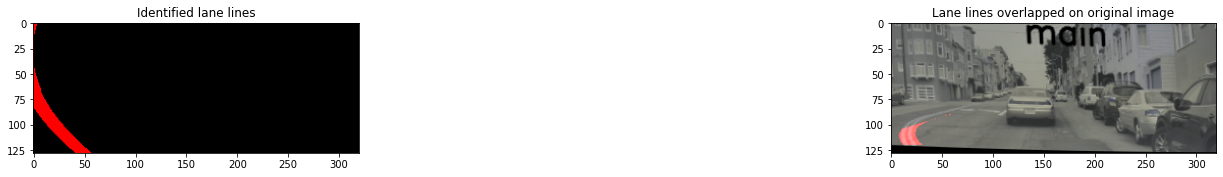

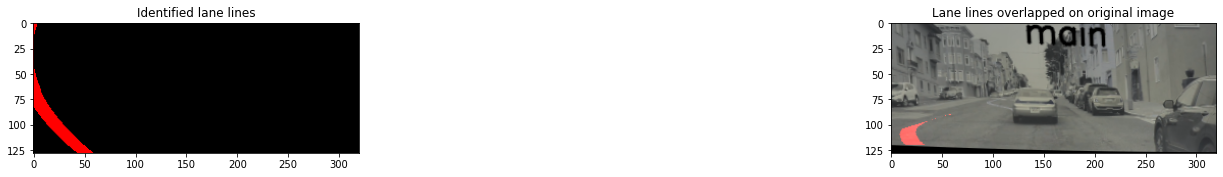

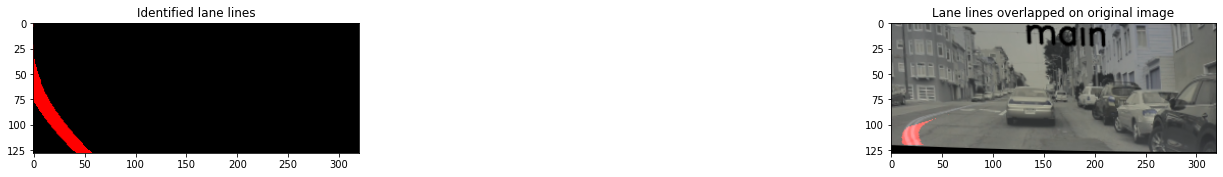

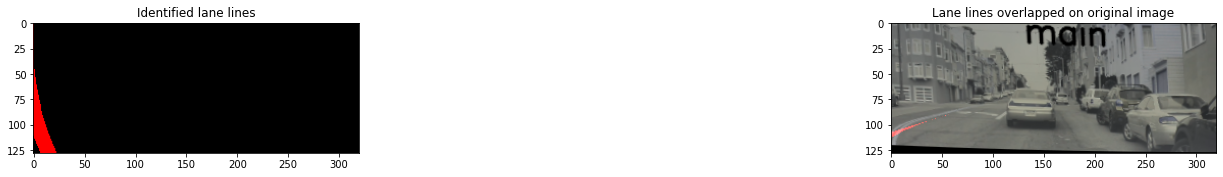

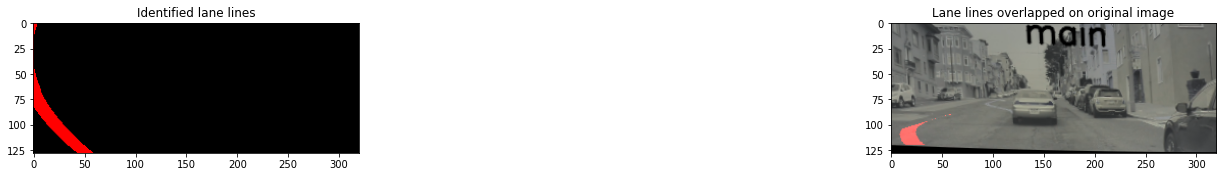

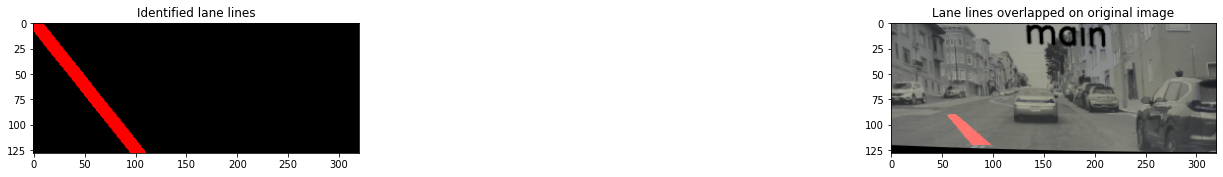

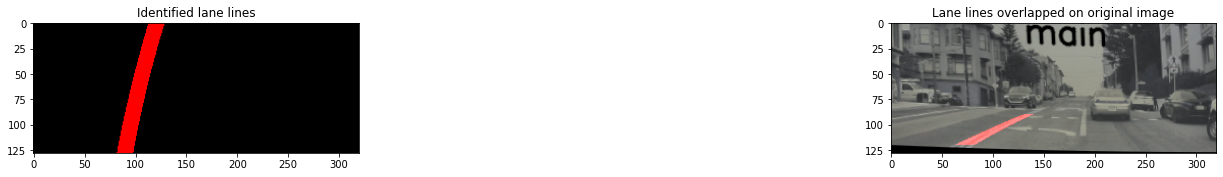

In [128]:
gidx=0

for idx,fname in enumerate(images):
    #read in image
    img = cv2.imread(fname)
    #undistort the image
    img = cv2.undistort(img,main_K,main_distortion,None,main_K)
    
    #pass image thru the pipeline
    preprocessImage = np.zeros_like(img[:,:,0])
    gradx = abs_sobel_thresh(img, orient='x', thresh_min=12, thresh_max=255)
    grady = abs_sobel_thresh(img, orient='y', thresh_min=25, thresh_max=255)
    c_binary = color_threshold(img, sthresh=(100,255), vthresh=(50,255))
    preprocessImage[((gradx == 1) & (grady ==1) | (c_binary == 1))] = 255
    
    img_size = (img.shape[1],img.shape[0])


    
    bot_width = .63 # percentage of bottom trapezoidal height
    mid_width = .32 # percentage of mid trapezoidal height
    height_pct = .7 # percentage of trapezoidal height
    bottom_trim= .935 # percentage from top to bottom avoiding the hood of the car


    
    src = np.float32([[img.shape[1]*(0.5-mid_width/2), img.shape[0]*height_pct],[img.shape[1]*(0.5+mid_width/2),img.shape[0]*height_pct],[img.shape[1]*(0.5+bot_width/2), img.shape[0]*bottom_trim],[img.shape[1]*(0.5-bot_width/2), img.shape[0]*bottom_trim]])
    offset = img_size[0]*0.25
    dst = np.float32([[offset,0],[img_size[0]-offset,0],[img_size[0]-offset,img_size[1]],[offset,img_size[1]]])
   
    #perform the warp perspective transform
    M = cv2.getPerspectiveTransform(src,dst)
    Minv = cv2.getPerspectiveTransform(dst,src)
    warped = cv2.warpPerspective(preprocessImage, M, img_size, flags=cv2.INTER_LINEAR)
    
    window_width = 15
    window_height = 15
    
    #set up the overall class to do the lane line tracking
    curve_centers = tracker(Mywindow_width=window_width, Mywindow_height=window_height, Mymargin = 12, My_ym = 10/720, My_xm = 4/384, Mysmooth_factor=15)
    
    window_centroids = curve_centers.find_window_centroids(warped)
    
    # Points used to draw all the left and right windows
    l_points = np.zeros_like(warped)
    r_points = np.zeros_like(warped)
        
    # points used to find the right & left lanes
    rightx = []
    leftx = []

    # Go through each level and draw the windows 
    for level in range(0,len(window_centroids)):
        # Window_mask is a function to draw window areas
        # Add center value found in frame to the list of lane points per left, right
        leftx.append(window_centroids[level][0])
        rightx.append(window_centroids[level][1])

        l_mask = window_mask(window_width,window_height,warped,window_centroids[level][0],level)
        r_mask = window_mask(window_width,window_height,warped,window_centroids[level][1],level)
        # Add graphic points from window mask here to total pixels found 
        l_points[(l_points == 255) | ((l_mask == 1) ) ] = 255
        r_points[(r_points == 255) | ((r_mask == 1) ) ] = 255


    # Draw the results
    template = np.array(r_points+l_points,np.uint8) # add both left and right window pixels together
    zero_channel = np.zeros_like(template) # create a zero color channel
    template = np.array(cv2.merge((zero_channel,template,zero_channel)),np.uint8) # make window pixels green
    warpage = np.array(cv2.merge((warped,warped,warped)),np.uint8) # making the original road pixels 3 color channels
    result = cv2.addWeighted(warpage, 1, template, 0.5, 0.0) # overlay the original road image with window results
    
    #fit the lane boundaries to the left, right center positions found
    yvals = range(0,warped.shape[0])
    
    res_yvals = np.arange(warped.shape[0]-(window_height/2),window_height/2,-window_height)
    
    print('len(res_rvals)', res_yvals, '\nlen leftx', leftx)
    print('\n', warped.shape)
    left_fit = np.polyfit(res_yvals, leftx, 2)
    left_fitx = left_fit[0]*yvals*yvals + left_fit[1]*yvals + left_fit[2]
    left_fitx = np.array(left_fitx,np.int32)
    
    """
    right_fit = np.polyfit(res_yvals, rightx, 2)
    right_fitx = right_fit[0]*yvals*yvals + right_fit[1]*yvals + right_fit[2]
    right_fitx = np.array(right_fitx,np.int32)
    """
    left_lane = np.array(list(zip(np.concatenate((left_fitx-window_width/2, left_fitx[::-1]+window_width/2),axis=0),np.concatenate((yvals,yvals[::-1]),axis=0))),np.int32)
    #right_lane = np.array(list(zip(np.concatenate((right_fitx-window_width/2, right_fitx[::-1]+window_width/2),axis=0),np.concatenate((yvals,yvals[::-1]),axis=0))),np.int32)

    road = np.zeros_like(img)
    road_bkg = np.zeros_like(img)
    cv2.fillPoly(road,[left_lane],color=[255,0,0])
    #cv2.fillPoly(road,[right_lane],color=[0,0,255])
    cv2.fillPoly(road_bkg,[left_lane],color=[255,255,255])
    #cv2.fillPoly(road_bkg,[right_lane],color=[255,255,255])

    road_warped = cv2.warpPerspective(road,Minv,img_size,flags=cv2.INTER_LINEAR)
    road_warped_bkg= cv2.warpPerspective(road_bkg,Minv,img_size,flags=cv2.INTER_LINEAR)
    
    base = cv2.addWeighted(img,1.0,road_warped, -1.0, 0.0)
    result = cv2.addWeighted(base,1.0,road_warped, 1.0, 0.0)

    #Visualize the results of identified lane lines and overlapping them on to the original undistorted image
    plt.figure(figsize = (30,20))
    grid = gridspec.GridSpec(8,2)
    # set the spacing between axes.
    grid.update(wspace=0.05, hspace=0.05)  

    #img_plt = plt.subplot(grid[0])
    plt.subplot(grid[gidx])
    plt.imshow(road, cmap="gray")
    plt.title('Identified lane lines')

    #img_plt = plt.subplot(grid[1])
    plt.subplot(grid[gidx+1])
    plt.imshow(result, cmap="gray")
    plt.title('Lane lines overlapped on original image')
    
plt.show()

### Calculate the radius of curvature using polynomial fit functions, and the position of the camera/car's center from the left or right lane. Display these results along with the fitted lane lines on top of the original image

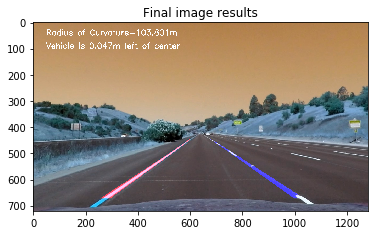

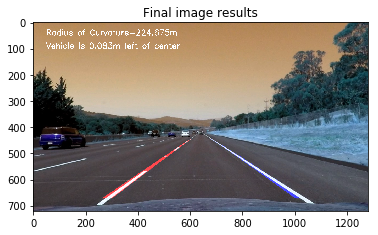

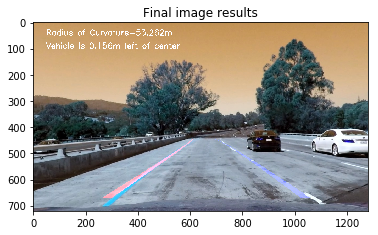

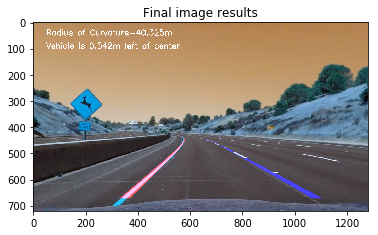

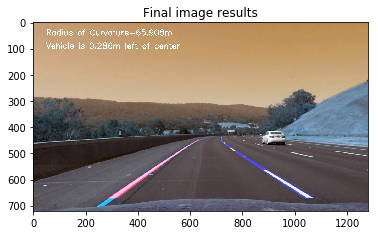

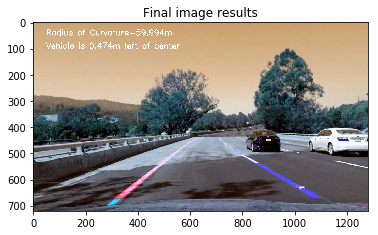

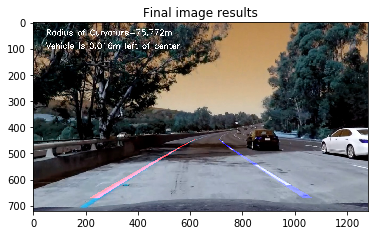

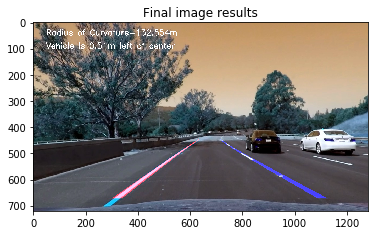

In [65]:
gidx=0

for idx,fname in enumerate(images):
    #read in image
    img = cv2.imread(fname)
    #undistort the image
    img = cv2.undistort(img,mtx,dist,None,mtx)
    
    preprocessImage = np.zeros_like(img[:,:,0])
    gradx = abs_sobel_thresh(img, orient='x', thresh_min=12, thresh_max=255)
    grady = abs_sobel_thresh(img, orient='y', thresh_min=25, thresh_max=255)
    c_binary = color_threshold(img, sthresh=(100,255), vthresh=(50,255))
    preprocessImage[((gradx == 1) & (grady ==1) | (c_binary == 1))] = 255

    img_size = (img.shape[1],img.shape[0])
    
    bot_width = .76 # percentage of bottom trapezoidal height
    mid_width = .08 # percentage of mid trapezoidal height
    height_pct = .62 # percentage of trapezoidal height
    bottom_trim= .935 # percentage from top to bottom avoiding the hood of the car
    
    src = np.float32([[img.shape[1]*(0.5-mid_width/2), img.shape[0]*height_pct],[img.shape[1]*(0.5+mid_width/2),img.shape[0]*height_pct],[img.shape[1]*(0.5+bot_width/2), img.shape[0]*bottom_trim],[img.shape[1]*(0.5-bot_width/2), img.shape[0]*bottom_trim]])
    offset = img_size[0]*0.25
    dst = np.float32([[offset,0],[img_size[0]-offset,0],[img_size[0]-offset,img_size[1]],[offset,img_size[1]]])   
    
    #perform the warp perspective transform
    M = cv2.getPerspectiveTransform(src,dst)
    Minv = cv2.getPerspectiveTransform(dst,src)
    warped = cv2.warpPerspective(preprocessImage, M, img_size, flags=cv2.INTER_LINEAR)
    
    window_width = 25
    window_height = 80
    
    #set up the overall class to do the lane line tracking
    curve_centers = tracker(Mywindow_width=window_width, Mywindow_height=window_height, Mymargin = 25, My_ym = 10/720, My_xm = 4/384, Mysmooth_factor=15)
    
    window_centroids = curve_centers.find_window_centroids(warped)
    
    # Points used to draw all the left and right windows
    l_points = np.zeros_like(warped)
    r_points = np.zeros_like(warped)
        
    # points used to find the right & left lanes
    rightx = []
    leftx = []

    # Go through each level and draw the windows 
    for level in range(0,len(window_centroids)):
        # Window_mask is a function to draw window areas
        # Add center value found in frame to the list of lane points per left, right
        leftx.append(window_centroids[level][0])
        rightx.append(window_centroids[level][1])

        l_mask = window_mask(window_width,window_height,warped,window_centroids[level][0],level)
        r_mask = window_mask(window_width,window_height,warped,window_centroids[level][1],level)
        # Add graphic points from window mask here to total pixels found 
        l_points[(l_points == 255) | ((l_mask == 1) ) ] = 255
        r_points[(r_points == 255) | ((r_mask == 1) ) ] = 255

    # Draw the results
    template = np.array(r_points+l_points,np.uint8) # add both left and right window pixels together
    zero_channel = np.zeros_like(template) # create a zero color channel
    template = np.array(cv2.merge((zero_channel,template,zero_channel)),np.uint8) # make window pixels green
    warpage = np.array(cv2.merge((warped,warped,warped)),np.uint8) # making the original road pixels 3 color channels
    result = cv2.addWeighted(warpage, 1, template, 0.5, 0.0) # overlay the original road image with window results
    
    #fit the lane boundaries to the left, right center positions found
    yvals = range(0,warped.shape[0])
    
    res_yvals = np.arange(warped.shape[0]-(window_height/2),0,-window_height)
    
    left_fit = np.polyfit(res_yvals, leftx, 2)
    left_fitx = left_fit[0]*yvals*yvals + left_fit[1]*yvals + left_fit[2]
    left_fitx = np.array(left_fitx,np.int32)
    
    right_fit = np.polyfit(res_yvals, rightx, 2)
    right_fitx = right_fit[0]*yvals*yvals + right_fit[1]*yvals + right_fit[2]
    right_fitx = np.array(right_fitx,np.int32)
    
    left_lane = np.array(list(zip(np.concatenate((left_fitx-window_width/2, left_fitx[::-1]+window_width/2),axis=0),np.concatenate((yvals,yvals[::-1]),axis=0))),np.int32)
    right_lane = np.array(list(zip(np.concatenate((right_fitx-window_width/2, right_fitx[::-1]+window_width/2),axis=0),np.concatenate((yvals,yvals[::-1]),axis=0))),np.int32)
    middle_marker = np.array(list(zip(np.concatenate((right_fitx-window_width/2, right_fitx[::-1]+window_width/2),axis=0),np.concatenate((yvals,yvals[::-1]),axis=0))),np.int32)

    road = np.zeros_like(img)
    road_bkg = np.zeros_like(img)
    cv2.fillPoly(road,[left_lane],color=[255,0,0])
    cv2.fillPoly(road,[right_lane],color=[0,0,255])
    cv2.fillPoly(road_bkg,[left_lane],color=[255,255,255])
    cv2.fillPoly(road_bkg,[right_lane],color=[255,255,255])

    road_warped = cv2.warpPerspective(road,Minv,img_size,flags=cv2.INTER_LINEAR)
    road_warped_bkg= cv2.warpPerspective(road_bkg,Minv,img_size,flags=cv2.INTER_LINEAR)
    
    base = cv2.addWeighted(img,1.0,road_warped, -1.0, 0.0)
    result = cv2.addWeighted(base,1.0,road_warped, 1.0, 0.0)
    ym_per_pix = curve_centers.ym_per_pix # meters per pixel in y dimension
    xm_per_pix = curve_centers.xm_per_pix # meters per pixel in x dimension

    curve_fit_cr = np.polyfit(np.array(res_yvals,np.float32)*ym_per_pix,np.array(leftx,np.float32)*xm_per_pix,2)
    curverad = ((1 + (2*curve_fit_cr[0]*yvals[-1]*ym_per_pix + curve_fit_cr[1])**2)**1.5) /np.absolute(2*curve_fit_cr[0])
    
    # Calculate the offset of the car on the road
    camera_center = (left_fitx[-1] + right_fitx[-1])/2
    center_diff = (camera_center-warped.shape[1]/2)*xm_per_pix
    side_pos = 'left'
    if center_diff <= 0:
        side_pos = 'right'

    # draw the text showing curvature, offset & speed
    cv2.putText(result, 'Radius of Curvature='+str(round(curverad,3))+'m ',(50,50),cv2.FONT_HERSHEY_SIMPLEX,1,(255,255,255),2)
    cv2.putText(result, 'Vehicle is '+str(abs(round(center_diff,3)))+'m '+side_pos+' of center',(50,100), cv2.FONT_HERSHEY_SIMPLEX,1,(255,255,255),2)

    plt.imshow(result, cmap='gray')
    plt.title('Final image results')
    plt.show()
    
    write_name='./test_images/tracked'+str(idx)+'.jpg'
    cv2.imwrite(write_name, result)

### Process videos to display the fitted lane lines, radius of curvature, and position of the car from the center

In [62]:
# Set up the process videos function
def process_image(img):
    #undistort the image
    img = cv2.undistort(img,mtx,dist,None,mtx)
    
    warptrap = np.copy(img)
    cv2.line(warptrap, (int(src[0][0]), int(src[0][1])), (int(src[1][0]), int(src[1][1])), [255,0,0], 10, cv2.LINE_AA)
    cv2.line(warptrap, (int(src[1][0]), int(src[1][1])), (int(src[2][0]), int(src[2][1])), [255,0,0], 10, cv2.LINE_AA)
    cv2.line(warptrap, (int(src[2][0]), int(src[2][1])), (int(src[3][0]), int(src[3][1])), [255,0,0], 10, cv2.LINE_AA)
    cv2.line(warptrap, (int(src[3][0]), int(src[3][1])), (int(src[0][0]), int(src[0][1])), [255,0,0], 10, cv2.LINE_AA)
    
    #pass image thru the pipeline
    #preprocessImage = np.zeros_like(img[:,:,0])
    #gradx = abs_sobel_thresh(img, orient='x',thresh_min=20, thresh_max=100)
    #s_binary = s_channel_threshold(img, sthresh=(170,255))
    #preprocessImage[((gradx == 1) | (s_binary == 1))] = 1
    preprocessImage = np.zeros_like(img[:,:,0])
    gradx = abs_sobel_thresh(img, orient='x', thresh_min=12, thresh_max=255)
    grady = abs_sobel_thresh(img, orient='y', thresh_min=25, thresh_max=255)
    c_binary = color_threshold(img, sthresh=(100,255), vthresh=(50,255))
    preprocessImage[((gradx == 1) & (grady ==1) | (c_binary == 1))] = 255

    binaryImage = np.copy(preprocessImage)
    binaryImage = np.array(cv2.merge((binaryImage,binaryImage,binaryImage)),np.uint8)
    cv2.putText(binaryImage, 'Binary Image',(50,50),cv2.FONT_HERSHEY_SIMPLEX,1,(0,255,0),2)
    
    img_size = (img.shape[1],img.shape[0])
    
    bot_width = .76 # percentage of bottom trapezoidal height
    mid_width = .08 # percentage of mid trapezoidal height
    height_pct = .62 # percentage of trapezoidal height
    bottom_trim= .935 # percentage from top to bottom avoiding the hood of the car
    
    src = np.float32([[img.shape[1]*(0.5-mid_width/2), img.shape[0]*height_pct],[img.shape[1]*(0.5+mid_width/2),img.shape[0]*height_pct],[img.shape[1]*(0.5+bot_width/2), img.shape[0]*bottom_trim],[img.shape[1]*(0.5-bot_width/2), img.shape[0]*bottom_trim]])
    offset = img_size[0]*0.25
    dst = np.float32([[offset,0],[img_size[0]-offset,0],[img_size[0]-offset,img_size[1]],[offset,img_size[1]]])   
    
    #perform the warp perspective transform
    M = cv2.getPerspectiveTransform(src,dst)
    Minv = cv2.getPerspectiveTransform(dst,src)
    warped = cv2.warpPerspective(preprocessImage, M, img_size, flags=cv2.INTER_LINEAR)
    
    window_width = 25
    window_height = 80
    
    #set up the overall class to do the lane line tracking
    curve_centers = tracker(Mywindow_width=window_width, Mywindow_height=window_height, Mymargin = 25, My_ym = 10/720, My_xm = 4/384, Mysmooth_factor=15)
    
    window_centroids = curve_centers.find_window_centroids(warped)
    
    # Points used to draw all the left and right windows
    l_points = np.zeros_like(warped)
    r_points = np.zeros_like(warped)
        
    # points used to find the right & left lanes
    rightx = []
    leftx = []

    # Go through each level and draw the windows 
    for level in range(0,len(window_centroids)):
        # Window_mask is a function to draw window areas
        # Add center value found in frame to the list of lane points per left, right
        leftx.append(window_centroids[level][0])
        rightx.append(window_centroids[level][1])

        l_mask = window_mask(window_width,window_height,warped,window_centroids[level][0],level)
        r_mask = window_mask(window_width,window_height,warped,window_centroids[level][1],level)
        # Add graphic points from window mask here to total pixels found 
        l_points[(l_points == 255) | ((l_mask == 1) ) ] = 255
        r_points[(r_points == 255) | ((r_mask == 1) ) ] = 255

    # Draw the results
    template = np.array(r_points+l_points,np.uint8) # add both left and right window pixels together
    zero_channel = np.zeros_like(template) # create a zero color channel
    template = np.array(cv2.merge((zero_channel,template,zero_channel)),np.uint8) # make window pixels green
    warpage = np.array(cv2.merge((warped,warped,warped)),np.uint8) # making the original road pixels 3 color channels
    result = cv2.addWeighted(warpage, 1, template, 0.5, 0.0) # overlay the original road image with window results

    windowfit = np.copy(result)
    cv2.putText(windowfit, 'Sliding window results',(50,50),cv2.FONT_HERSHEY_SIMPLEX,1,(0,255,0),2)
    
    warpage1 = np.copy(warpage)
    cv2.putText(warpage1, 'Bird\'s-eye View',(50,50),cv2.FONT_HERSHEY_SIMPLEX,1,(0,255,0),2)
    cv2.line(warpage1, (int(dst[0][0]), int(dst[0][1])), (int(dst[1][0]), int(dst[1][1])), [0,0,255], 10, cv2.LINE_AA)
    cv2.line(warpage1, (int(dst[1][0]), int(dst[1][1])), (int(dst[2][0]), int(dst[2][1])), [0,0,255], 10, cv2.LINE_AA)
    cv2.line(warpage1, (int(dst[2][0]), int(dst[2][1])), (int(dst[3][0]), int(dst[3][1])), [0,0,255], 10, cv2.LINE_AA)
    cv2.line(warpage1, (int(dst[3][0]), int(dst[3][1])), (int(dst[0][0]), int(dst[0][1])), [0,0,255], 10, cv2.LINE_AA)
    
    #fit the lane boundaries to the left, right center positions found
    yvals = range(0,warped.shape[0])
    
    res_yvals = np.arange(warped.shape[0]-(window_height/2),0,-window_height)
    
    left_fit = np.polyfit(res_yvals, leftx, 2)
    left_fitx = left_fit[0]*yvals*yvals + left_fit[1]*yvals + left_fit[2]
    left_fitx = np.array(left_fitx,np.int32)
    
    right_fit = np.polyfit(res_yvals, rightx, 2)
    right_fitx = right_fit[0]*yvals*yvals + right_fit[1]*yvals + right_fit[2]
    right_fitx = np.array(right_fitx,np.int32)
    
    left_lane = np.array(list(zip(np.concatenate((left_fitx-window_width/2, left_fitx[::-1]+window_width/2),axis=0),np.concatenate((yvals,yvals[::-1]),axis=0))),np.int32)
    right_lane = np.array(list(zip(np.concatenate((right_fitx-window_width/2, right_fitx[::-1]+window_width/2),axis=0),np.concatenate((yvals,yvals[::-1]),axis=0))),np.int32)
    middle_marker = np.array(list(zip(np.concatenate((right_fitx-window_width/2, right_fitx[::-1]+window_width/2),axis=0),np.concatenate((yvals,yvals[::-1]),axis=0))),np.int32)
    inner_lane = np.array(list(zip(np.concatenate((left_fitx+window_width/2, right_fitx[::-1]-window_width/2),axis=0),np.concatenate((yvals,yvals[::-1]),axis=0))),np.int32)

    road = np.zeros_like(img)
    road_bkg = np.zeros_like(img)
    cv2.fillPoly(road,[left_lane],color=[255,0,0])
    cv2.fillPoly(road,[right_lane],color=[0,0,255])
    cv2.fillPoly(road,[inner_lane],color=[0,255,0])
    cv2.fillPoly(road_bkg,[left_lane],color=[255,255,255])
    cv2.fillPoly(road_bkg,[right_lane],color=[255,255,255])
    
    #Results screen portion for polynomial fit
    road1 = np.copy(road)
    cv2.putText(road1, 'Polynomial fit',(50,50),cv2.FONT_HERSHEY_SIMPLEX,1,(0,255,0),2)
    
    road_warped = cv2.warpPerspective(road,Minv,img_size,flags=cv2.INTER_LINEAR)
    road_warped_bkg= cv2.warpPerspective(road_bkg,Minv,img_size,flags=cv2.INTER_LINEAR)
    
    base = cv2.addWeighted(img,1.0,road_warped, -1.0, 0.0)
    result = cv2.addWeighted(base,1.0,road_warped, 1.0, 0.0)
    ym_per_pix = curve_centers.ym_per_pix # meters per pixel in y dimension
    xm_per_pix = curve_centers.xm_per_pix # meters per pixel in x dimension

    curve_fit_cr = np.polyfit(np.array(res_yvals,np.float32)*ym_per_pix,np.array(leftx,np.float32)*xm_per_pix,2)
    curverad = ((1 + (2*curve_fit_cr[0]*yvals[-1]*ym_per_pix + curve_fit_cr[1])**2)**1.5) /np.absolute(2*curve_fit_cr[0])
    
    # Calculate the offset of the car on the road
    camera_center = (left_fitx[-1] + right_fitx[-1])/2
    center_diff = (camera_center-warped.shape[1]/2)*xm_per_pix
    side_pos = 'left'
    if center_diff <= 0:
        side_pos = 'right'

    # draw the text showing curvature, offset & speed
    cv2.putText(result, 'Radius of Curvature='+str(round(curverad,3))+'m ',(50,50),cv2.FONT_HERSHEY_SIMPLEX,1,(255,255,255),2)
    cv2.putText(result, 'Vehicle is '+str(abs(round(center_diff,3)))+'m '+side_pos+' of center',(50,100), cv2.FONT_HERSHEY_SIMPLEX,1,(255,255,255),2)

    height, width = 1080, 1920
    FinalScreen = np.zeros((height, width, 3), dtype=np.uint8)
    FinalScreen[0:720,0:1280] = cv2.resize(result, (1280,720), interpolation=cv2.INTER_AREA)
    FinalScreen[0:360,1280:1920] = cv2.resize(warptrap, (640,360), interpolation=cv2.INTER_AREA)
    FinalScreen[360:720,1280:1920] = cv2.resize(binaryImage, (640,360), interpolation=cv2.INTER_AREA)
    FinalScreen[720:1080,1280:1920] = cv2.resize(warpage1, (640,360), interpolation=cv2.INTER_AREA)
    FinalScreen[720:1080,0:640] = cv2.resize(windowfit, (640,360), interpolation=cv2.INTER_AREA)
    FinalScreen[720:1080,640:1280] = cv2.resize(road1, (640,360), interpolation=cv2.INTER_AREA)
    return FinalScreen

Output_video = 'output1_tracked.mp4'
Input_video = 'project_video.mp4'
#Output_video = 'output_challenge_video.mp4'
#Input_video = 'harder_challenge_video.mp4'
#Output_video = 'output_challenge_video.mp4'
#Input_video = 'challenge_video.mp4'

clip1 = VideoFileClip(Input_video)
video_clip = clip1.fl_image(process_image) # This function expects color images
video_clip.write_videofile(Output_video, audio=False)


[MoviePy] >>>> Building video output1_tracked.mp4
[MoviePy] Writing video output1_tracked.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [03:29<00:00,  5.87it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output1_tracked.mp4 



### Summary: The above solution works well on the standard video. However, it needs to be improved for the challenge videos. This is because the lanes are different in the challenge video: half of the lane is a freshly paved road and is different in color with the other other half of the lane. Also, the harder challenge video has glare on the camera as a result of direct sunlight falling on it, as well as high contrast contributing to washed out lane lines. This creates problems for the algorithm. One solution would be to dynamically adjust the contrast of the image frames dynamically to ensure images are not washed out and make sure they have a good dynamic range to work with in all lighting conditions. The harder challenge videos also have roads which are curvy and have a slope which makes it difficult to warp the images properly to feed into the algorithm. This can also be addressed by creating a dynamic region of interest for each image frame. These are some of the things that need to be explored when time permits. Overall, there is a lot of trail and error process in this project which makes it quite time consuming.